In [1]:
import cv2
import matplotlib.pyplot as plt
import torch

import Inference
import Filter
import rrrc_cpp

In [2]:
img = cv2.imread("/home/artl2sch/Desktop/Robotic_Perception/C++/FastCropRotate/0-0.png")
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = cv2.resize(img, [2000, 2000])

In [3]:
out_n = 1000

with torch.no_grad():    

    input_image  =  torch.tensor(img, dtype = torch.uint8)[None, :, :].contiguous().cuda()
    output_images = torch.zeros([out_n, 1, 128, 128], dtype = torch.float32).contiguous().cuda()

    M = torch.tensor([1.0, 0.0, 0.0, 1.0]*out_n, dtype = torch.float32)
    M_rand = torch.rand_like(M)
    M += M_rand * 0.5

    M *= input_image.shape[-1]/output_images.shape[-1]
    T = torch.tensor([0.0, 0.0]*out_n, dtype = torch.float32)

In [4]:
ONNX_FILE_PATH = './Weights/model.onnx'
with torch.no_grad():    
    trt_model = Inference.TRTModel(out_n, ONNX_FILE_PATH)
    trt_model.build_engine()
    trt_model.reserve_cuda_memory()

[06/30/2023-04:23:53] [TRT] [W] CUDA lazy loading is not enabled. Enabling it can significantly reduce device memory usage and speed up TensorRT initialization. See "Lazy Loading" section of CUDA documentation https://docs.nvidia.com/cuda/cuda-c-programming-guide/index.html#lazy-loading
[06/30/2023-04:24:18] [TRT] [W] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[06/30/2023-04:24:18] [TRT] [W] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[06/30/2023-04:24:18] [TRT] [W] Check verbose logs for the list of affected weights.
[06/30/2023-04:24:18] [TRT] [W] - 24 weights are affected by this issue: Detected subnormal FP16 values.
[06/30/2023-04:24:18] [TRT] [W] - 10 weights are affected by this issue: Detected values less than smallest positive FP16 subnormal value and converted them to the FP16 minimum subnormalized value.
[06/30/2023-04:24:18] [TRT] 

In [5]:
with torch.no_grad():
    pf = Filter.ParticleFilter(out_n)
    displacement_val = torch.tensor([0.1, 0.0, 0.0, 0.0], dtype = torch.float32).cuda()
    displacement_var = torch.tensor([0.0, 0.0, 0.0, 0.1], dtype = torch.float32).cuda()

In [6]:
n_steps = 100

import time

loop_time = -time.time()

for i in range(n_steps):
    with torch.no_grad():    

        rrrc_cpp.rrrc(input_image, output_images, M, T)

        output_images_3 = output_images.repeat(1, 3, 1, 1)
  
        embeddings = trt_model.run(output_images_3)

        pf.resample(embeddings)

        pf.move(displacement_val, displacement_var)


loop_time += time.time()
loop_time /= n_steps

print ("loop time : ", loop_time)

loop time :  0.01550049066543579


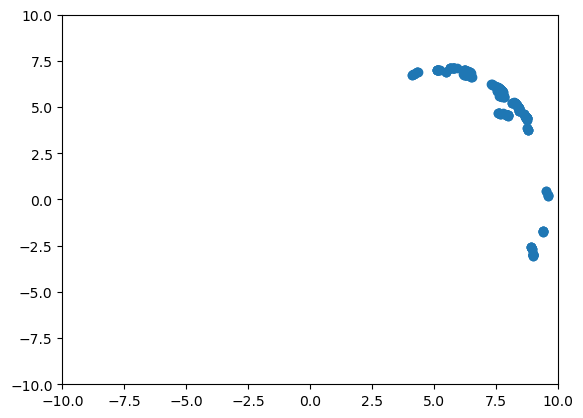

init time :  0.0013928413391113281
move time :  0.0012871766090393067
resample time :  0.0007695484161376953


In [52]:
pf.draw_particles()
pf.print_times()

In [7]:
embeddings.shape

torch.Size([500, 128])